In [33]:
import os
import shutil
import random
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall


# === IMAGE PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 32

# Data Preprocessing

In [34]:
dataset_path = "dataset/input"
output_dir = "dataset/split_dataset"
os.makedirs(output_dir, exist_ok=True)

all_images = []
all_labels = []

for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            all_images.append(img_path)
            all_labels.append(class_name)

df = pd.DataFrame({"image": all_images, "label": all_labels})

# Split the dataset into training (60%), validation (20%), and test sets (20%)
train_df, temp_df = train_test_split(
    df, test_size=0.4, stratify=df["label"], random_state=42
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

print(f"Total images: {len(df)}")
print(f"Labels: {set(all_labels)}")


print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Total images: 15000
Labels: {'adenocarcinoma', 'benign', 'squamous_cell_carcinoma'}
Training set size: 9000
Validation set size: 3000
Test set size: 3000


In [35]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

test_generator = val_datagen.flow_from_dataframe(
    test_df,
    x_col="image",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False,
)

Found 9000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.
Found 3000 validated image filenames belonging to 3 classes.


(32, 224, 224, 3)
[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]]


<Figure size 640x480 with 0 Axes>

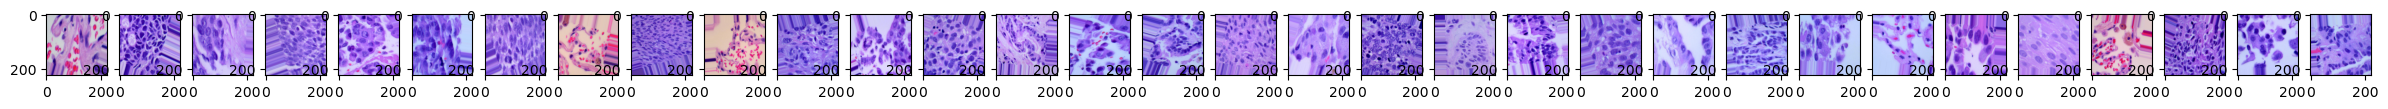

In [36]:
images, labels = train_generator[0]
print(images.shape)
print(labels)

plt.figure()

# subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1, images.shape[0], figsize=(30, 4))


for i in range(images.shape[0]):
    axarr[i].imshow(images[i])

In [37]:
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
FILTER1_SIZE = 32
FILTER2_SIZE = 64
FILTER_SHAPE = (3, 3)
POOL_SHAPE = (2, 2)
FULLY_CONNECT_NUM = 128
NUM_CLASSES = len(train_generator.class_indices)
METRICS = metrics = ["accuracy", Precision(name="precision"), Recall(name="recall")]
EPOCHS = 10

# Model architecture implementation
model = Sequential()
model.add(
    Conv2D(FILTER1_SIZE, FILTER_SHAPE, activation="relu", input_shape=INPUT_SHAPE)
)
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Conv2D(FILTER2_SIZE, FILTER_SHAPE, activation="relu"))
model.add(MaxPooling2D(POOL_SHAPE))
model.add(Flatten())
model.add(Dense(FULLY_CONNECT_NUM, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.summary()

model.compile(
    loss="categorical_crossentropy",
    optimizer=RMSprop(learning_rate=2e-5),
    metrics=["acc"],
)

c:\Users\sgarn\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      23,888,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\sgarn\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 265s 935ms/step - acc: 0.6620 - loss: 0.7217 - val_acc: 0.7217 - val_loss: 0.5075
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 155s 550ms/step - acc: 0.7764 - loss: 0.4547 - val_acc: 0.7793 - val_loss: 0.4362
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 150s 531ms/step - acc: 0.8153 - loss: 0.4108 - val_acc: 0.8243 - val_loss: 0.3961
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 419s 1s/step - acc: 0.8384 - loss: 0.3880 - val_acc: 0.8397 - val_loss: 0.3687
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 208s 730ms/step - acc: 0.8492 - loss: 0.3685 - val_acc: 0.8517 - val_loss: 0.3549
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 152s 538ms/step - acc: 0.8580 - loss: 0.3407 - val_acc: 0.8563 - val_loss: 0.3372
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 150s 532ms/step - acc: 0.8590 - loss: 0.3345 - val_acc: 0.8587 - val_loss: 0.3362
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 151s 536ms/step - acc: 0.8631 - loss: 0.3196 - val_acc: 0.8617 - val_loss: 0.3099
Epoch 9/10
282/282 ━━━━━━━━

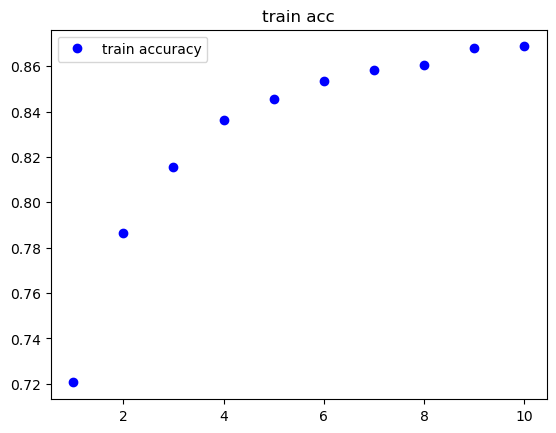

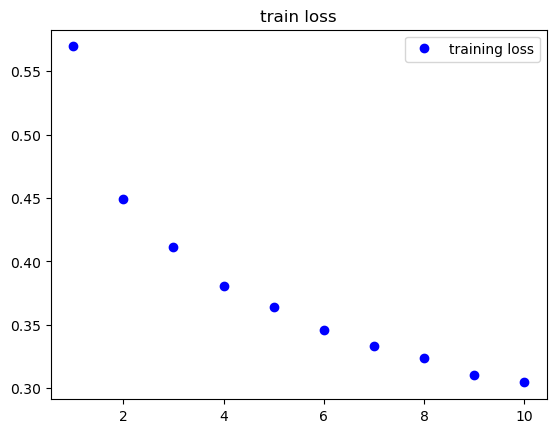

In [38]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
)

acc = history.history["acc"]
loss = history.history["loss"]

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label="train accuracy")
plt.title("train acc")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="training loss")
plt.title("train loss")
plt.legend()

plt.show()

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

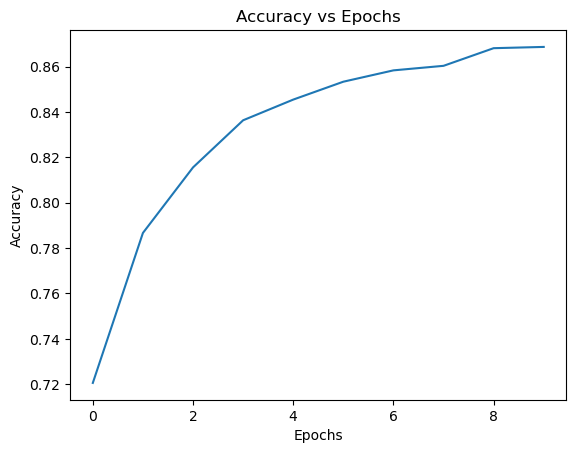

In [39]:
# Run this cell to load the model history into a pandas DataFrame

frame = pd.DataFrame(history.history)

acc_plot = frame.plot(y="acc", title="Accuracy vs Epochs", legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Accuracy")

[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Loss')]

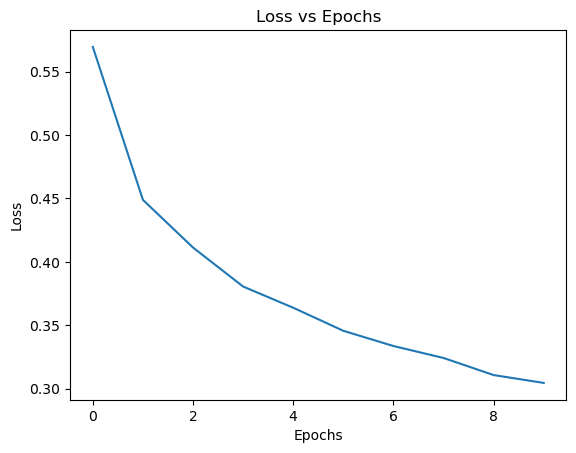

In [40]:
acc_plot = frame.plot(y="loss", title="Loss vs Epochs", legend=False)
acc_plot.set(xlabel="Epochs", ylabel="Loss")